# The idea behind the GP

##### Keywords: normal distribution, multivariate normal, marginal, conditional, priors, correlation, covariance, kernel, posterior, posterior predictive, gaussian process, regression

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## A quick primer on gaussian multivariate gaussians

* EQUATION A: For a multivariate gaussian the distribution is:

$$p(x \mid \mu, \Sigma) = (2\pi)^{-n/2}|\Sigma|^{-1/2} \exp\left\{ -\frac{1}{2} (x-\mu)^{\prime}\Sigma^{-1}(x-\mu) \right\}$$

* EQUATION B: marginals of multivariate normal distributions are normal

$$p(x,y) = \mathcal{N}\left(\left[{
\begin{array}{c}
  {\mu_x}  \\
  {\mu_y}  \\
\end{array}
}\right], \left[{
\begin{array}{c}
  {\Sigma_x} & {\Sigma_{xy}}  \\
  {\Sigma_{xy}^T} & {\Sigma_y}  \\
\end{array}
}\right]\right)$$

$$p(x) = \int p(x,y) dy = \mathcal{N}(\mu_x, \Sigma_x)$$

* EQUATION C: conditionals of multivariate normals are normal

$$p(x \mid y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), 
\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T)$$

Another way of looking at these is provided in Murphy Chapter 4:

![](images/gcondmarg.png)

## Modeling correlation

We have seen from the oceanic tools example that we can model a geographical correlation from our 10 societies as setting intercept parameters for each society. Lets see this play out in a more general form here. Consider a regression problem where you have some $x$ and $y$ values, and want to predict the y at some new x. There is no assumption of a straight line fit here: our fits may be as complicated as we desire: lets call the underlying function $f$.

There is a general expectation of continuity as you move from one adjacent point to another. That is, in the absence of significant noise, two adjacent points ought to have fairly similar $f$ values. This assumption is captured by assuming there is some correlation length in the problem, as represented by the **exponential kernel** below. 

$$ k(x_i, x_j) = \sigma_f^2 exp( \frac{-(x_i-x_j)^2}{2l^2}) $$

A small correlation length means that we do not expect points further than this small length to be correlated. A large one means that the functions are smooth and not-wiggly over large distances, possibly encompassing many points.

In [2]:
def exp_kernel(x1,x2, params):
    amplitude=params[0]
    scale=params[1]
    return amplitude * amplitude*np.exp(-((x1-x2)**2) / (2.0*scale))


Having captured this notion via a kernel, we can construct a covariance matrix between points $\{x_1\}$ and $\{x_2\}$ using this kernel pointwise

In [3]:
covariance = lambda kernel, x1, x2, params: \
    np.array([[kernel(xi1, xi2, params) for xi1 in x1] for xi2 in x2])

Now let us assume that we use this covariance matrix to produce draws from a 0-mean, NxN covariance matrix given multivariate-gaussian. This will give us N-draws from the gaussian, which we can plot. We do so below for different correlation lengths. Notice we have added a small nose term. 

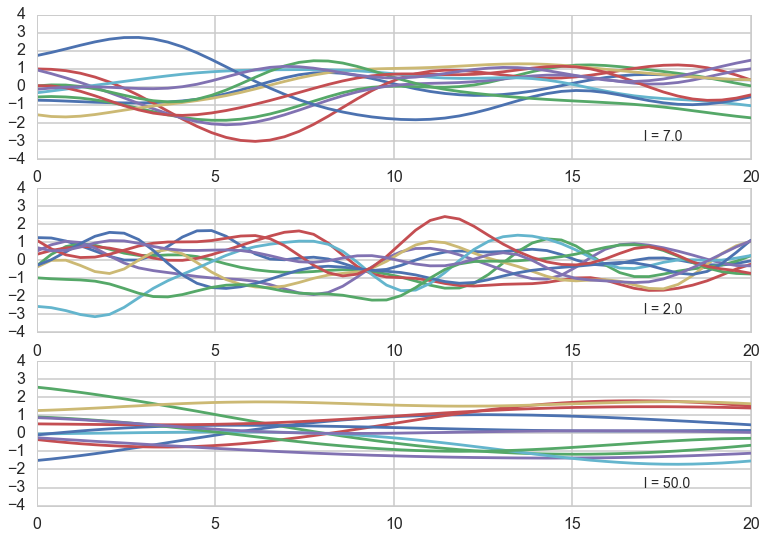

In [12]:
l = [7.0, 2.0, 50.0]
a = 1.0
nsamps = 50
xx = np.linspace(0,20,nsamps)
for ell, p in zip(l,[1,2,3]):
    sigma = covariance(exp_kernel,xx,xx, [a,ell]) + np.eye(nsamps)*1e-06

    for i in range(10):
        samples = np.random.multivariate_normal(np.zeros(nsamps), sigma)
        plt.subplot(int("31{}".format(p)))
        plt.plot(xx, samples)
    plt.annotate("l = {}".format(ell), xy=(17,-3), fontsize=14)
    plt.ylim(-4,4)

Notice how, the greater the correlation length, the smoother the curve.

What have we done? We have not seen any data yet, but based on the notion that we expect the function representing our data to have some level of continuity, we have decided to consider different functions that might represent our data, as having come from MVNs with a covariance matrix based on the correlation length. 

The diagram below illustrates this idea. The red curve represents one of these functions from the calculation above. We have 3 red data points, so it would be seem to be one of the curves consistent with the data.

The little axis diagram illustrates that because of the way we are generating our curves before we select some of them, we can consider the curve as a point in a multi-dimensional space, a draw from a multivariate gaussian with as many points as points on the curve. You might protest that this is then an infinite MVN, and you would be right, but lets ignore that for now and imagine its finite. (We'll come back to the infinite case soon).

Now, as is typical in regression we consider the data to have been generated IID from some regression function $f(x)$ (like $w \cdot x$ in simple linear regression) with some noise $\sigma^2$ at each point. This is illustrated below by the 3 gaussians. Then the data itself can be thought of as generated from a univariate normal with $f(x)$ as the mean.


![](images/gproc.png)

Lets zoom into curves corresponding to $l=7$. Again we have added a small noise term. All the theory holds without the noise term, but adding the noise term shows us the most general structure.

(-4, 4)

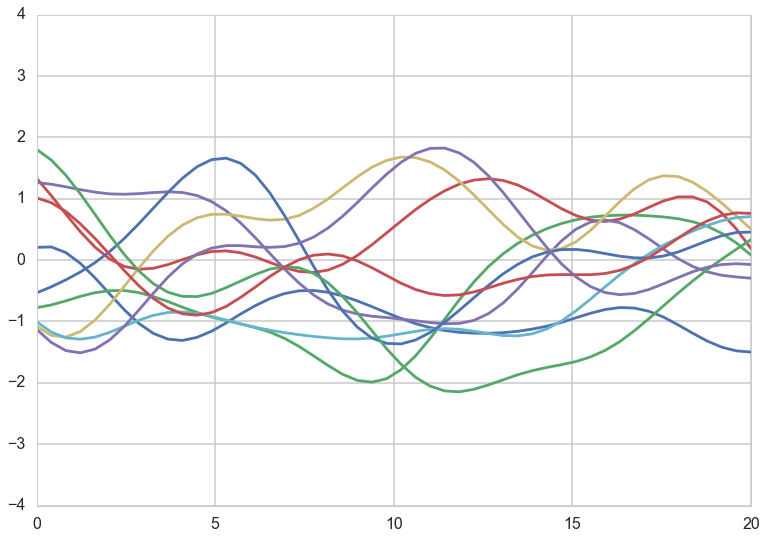

In [22]:

ell = 7.0
a = 1.0
nsamps = 50

x_star = np.linspace(0,20,nsamps)
sigma = covariance(exp_kernel,xx,xx, [a,ell]) + np.eye(nsamps)*1e-06
for i in range(10):
    samples = np.random.multivariate_normal(np.zeros(nsamps), sigma)
    plt.plot(x_star, samples)
plt.ylim(-4,4)

Now we add some data. This data can be thought of as augmenting the dimension of our multivariate normal in a structure that is captured by the formulae we wrote down at the beginning of this notebook:

$$JOINT: \,\,p(y,f^{*}) = \mathcal{N}\left(\left[{
\begin{array}{c}
  {\mu_y}  \\
  {\mu_{f^{*}}}  \\
\end{array}
}\right], \left[{
\begin{array}{c}
  {\Sigma_{yy}} & {\Sigma_{yf^{*}}}  \\
  {\Sigma_{yf^{*}}^T} & {\Sigma_{f^{*}f^{*}}}  \\
\end{array}
}\right]\right) = \mathcal{N}\left(\left[{
\begin{array}{c}
  {\mu}  \\
  {\mu_{*}}  \\
\end{array}
}\right], \left[{
\begin{array}{c}
  K + \sigma^2 I & {K_{*}}  \\
  {K_{*}^T} & K_{**}  \\
\end{array}
}\right]\right)$$

$$MARGINAL: \,\,p(f^{*}) = \int p(f^{*},y) dy = \mathcal{N}(\mu_{*}, K_{**})$$


$$CONDITIONAL: \,\, p(f^{*} \mid y) = \mathcal{N}\left(\mu_{*} + K_{*}(K + \sigma^2 I)^{-1}(y-\mu), \,\,
K_{**}-K_{*}(K + \sigma^2 I)^{-1}K_{*}^T \right)$$

Note here that:

$$K = K(x, x); K_{*} = K(x, x^{*}); K_{**} = K(x^{*}, x^{*})$$

are the covariance matrices calculated at the corresponding x positions!
Without loss of generality we can set the means to 0.

Notice that the conditional formula, because of the structure of the problem, directly gives us a **predictive** distribution!! We did not need to marginalize over a posterior or anything. Whats happened here? This will become clear when we introduce the gaussian process.

In [30]:
# defining the training data
x = np.array([5.0, 10.0, 15.0])
f = np.array([1.0, -1.0, -2.0]).reshape(-1,1)
print(f)


K = covariance(exp_kernel, x,x,[a,ell]) 

K_star = covariance(exp_kernel,x,x_star,[a,ell])
K_star_star = covariance(exp_kernel, x_star, x_star, [a,ell])
K_inv = np.linalg.inv(K)

[[ 1.]
 [-1.]
 [-2.]]


In [32]:
K.shape, K_star.shape, K_star_star.shape, K_inv.shape

((3, 3), (50, 3), (50, 50), (3, 3))

In [34]:
mu_star = np.dot(np.dot(K_star, K_inv),f) 
sigma_star = K_star_star  - np.dot(np.dot(K_star, K_inv),K_star.T)

In [37]:
sigma_star.shape

(50, 50)

Now we draw samples from a MVN using the newly calculated $\mu_{*}$ and $K_{**}$. Notice how these **predictive curves** pinch through the data points.

//anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  from ipykernel import kernelapp as app


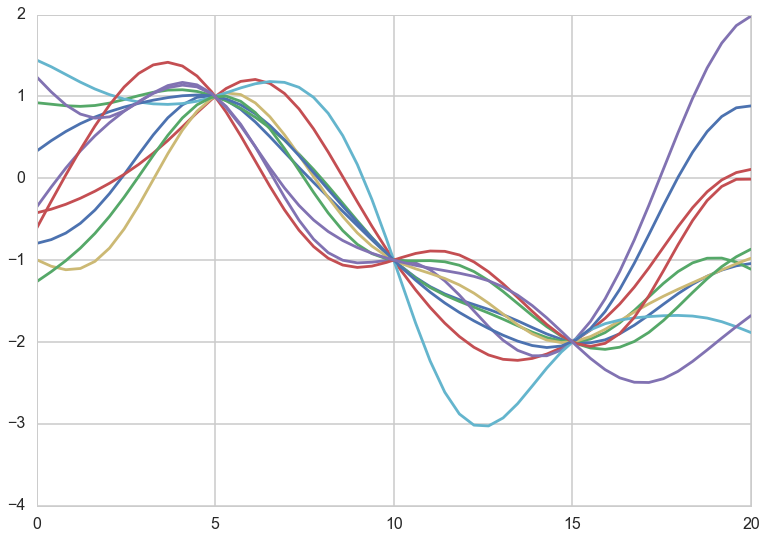

In [40]:
for i in range(10):
    samples = np.random.multivariate_normal(mu_star.flatten(), sigma_star)
    plt.plot(x_star, samples)

For a better visualization we can directly plot the mean curve and a shaded area for the standard deviation

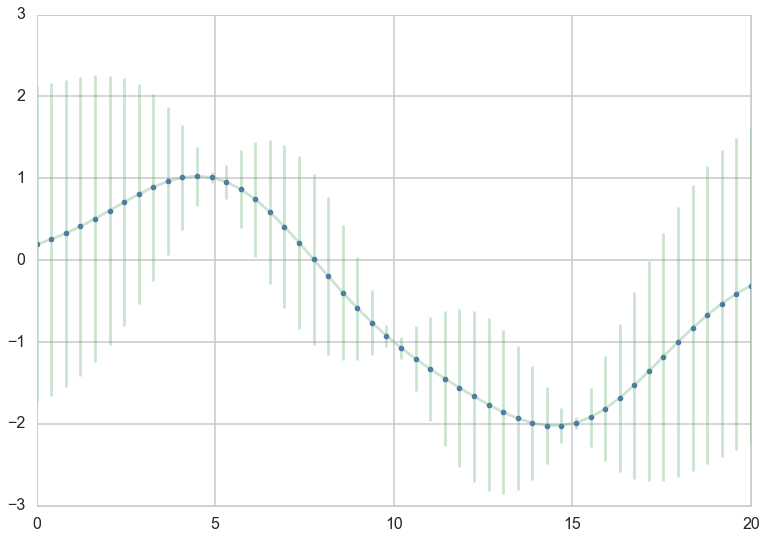

In [41]:
plt.plot(x_star, mu_star, '.')
plt.errorbar(x_star, mu_star, yerr=1.96*np.sqrt(sigma_star.diagonal()), alpha=0.3);

We are still in the noiseless scenario, so the GP goes directly through the data points we specified, and there is no uncertainty about our measurements. As you can see the further away from a data point the GP is making predictions, the more uncertainty we have. 

No let's add some noise to our scenario. We assume $y = f(x) + \epsilon$ with $\epsilon \sim N(0, \sigma^2)$

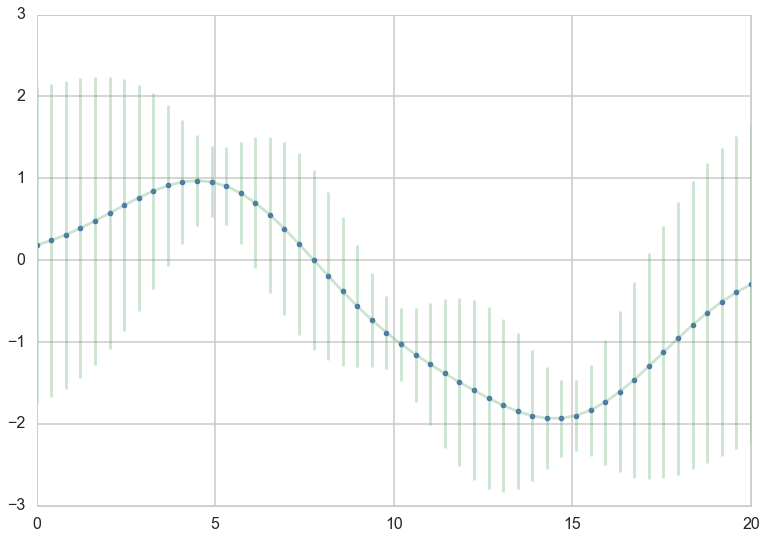

In [42]:
sigma_epsilon_sq = 0.05

K_noise = K + np.diag([sigma_epsilon_sq] * K.shape[0])  
K_noise_inv = np.linalg.inv(K_noise)

mu_star_noise = np.dot(np.dot(K_star, K_noise_inv),f) # the one comes from the f= 1.0 for our data point
sigma_star_noise = K_star_star  - np.dot(np.dot(K_star, K_noise_inv),K_star.T)

plt.plot(x_star, mu_star_noise, '.')
plt.errorbar(x_star, mu_star_noise, yerr=1.96*np.sqrt(sigma_star_noise.diagonal()), alpha=0.3);

Knowing that our measurements contain noise, makes us less certain, even if we observed some data. 

Let us also look at the numerically more stable version. The Cholesky matrix is the matrix equivalent of the square root of the variance.

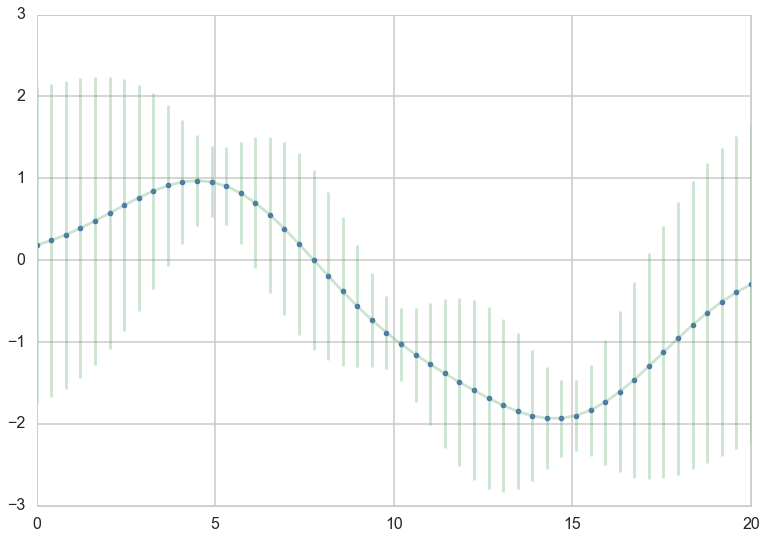

In [45]:
L = np.linalg.cholesky(K_noise)
#numpy.linalg.solve(a, b)
#Computes the “exact” solution, x, of the well-determined, i.e., full rank, linear matrix equation ax = b.
m = np.linalg.solve(L,f)
alpha = np.linalg.solve(L.T,m)
mu_star_noise_c = np.dot(K_star, alpha)

v = np.linalg.solve(L,K_star.T)
sigma_star_noise_c = K_star_star  - np.dot(v.T,v)


plt.plot(x_star, mu_star_noise_c, '.')
plt.errorbar(x_star, mu_star_noise, yerr=1.96*np.sqrt(sigma_star_noise_c.diagonal()), alpha=0.3);

So what just happened here?

1. We built a covariance matrix from a kernel function
2. The parameters of the kernel function became parameters of the covariance matrix
3. we use the covariance matrix to generate a "curve" as a point in a multi-dimensional space from a MVN
4. multiple such curves serve as **prior** fits for our data
5. now we bring in the data and condition on it (with noise added if needed) using the normal distribution formulae
6. the conditional has the form of a predictive and we are done
7. Also notice that the marginal only has quantities from the predictive block. This means that we dont care about the size of the original block in calculating the marginal.

These observations are the building blocks of the GP.